In [55]:
from netCDF4 import Dataset, num2date
import cartopy.crs as ccrs
import cartopy.feature as cf
from sklearn.utils import shuffle
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import time
import os

In [97]:
"""
DEFINIMOS EL PATH BASE DEL PROYECTO
"""
path_base = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis'
path_imagenes = 'F:/GOES/' 
imagenTest = 'D:/GOES/C13/2020/03/G16_C13_Cyl_20200320-2000.nc'
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'

#Variables generales
products = ['C07','C08','C13']

#!El '00' debe ir al final!
times = ['10','20','30','40','50','00']

In [3]:
def changeUmbralesFileName(DUmbrales):
    FUmbrales = os.listdir(DUmbrales)
    start_time = time.time()
    errors = []
    for umbName in FUmbrales:
        tempUmb = pd.read_csv(f'{DUmbrales}/{umbName}', nrows=5, sep=';')
        try:
            os.rename(f'{DUmbrales}/{umbName}', f'{DUmbrales}/UMBRAL-{tempUmb["IDESTACION"][0]}.csv')
        except:
            errors.append(tempUmb)
    
    print(f'Cantidad de archivos procesados:       {len(FUmbrales)}')
    print(f'Archivos que no se pudieron renombrar: {len(errors)}')
    print(f"Tiempo tomado en renombrar:             %.5fs" % (time.time() - start_time))
    return errors
    

In [4]:
"""
Clasificacion V2
 - NC
 - ND
 - M01
 - D01
 - D02
 - C01 
"""
def getFlagV2(x, umbrales):
    dato = x['PRECIPITACION']
    
    # No existe dato
    if pd.isna(dato):
        return 'ND'
    
    # Test DUROS
    elif dato<0 or dato>=401:
        return 'M01'
    
    codigo = str(x['CODIGO'])
    mes =  int(x['FECHA'].split('/')[1]) -1
    hora = int(x['HORA'].split(':')[0])
    
    if not codigo in list(umbrales.keys()):
        val1 = -1
        val2 = -1
    else:
        val1 = umbrales[codigo][mes][hora][0]
        val2 = umbrales[codigo][mes][hora][1]
    
    # No existe umbrales
    if (val1==-1) and (val2==-1):
        return 'NC'
    
    
    # Umbral 2
    if dato > val2:
        return 'D02'
    
    # Umbral 1
    if dato > val1:
        return 'D01'       
    
    # Conforme    
    return 'C01'
    

In [ ]:
def applyFlagV2(listDS, umbrales):
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    for name in listDS:
        try:
            df.append(pd.read_csv(name,encoding='latin-1'))   
        except:
            print(f'No se pudo leer el archivo {name} de dataset')
            return -1
        
    if len(df)>1:
        dsCompleto =  pd.concat(df, ignore_index=True) 
    else:
        dsCompleto =  df[0]
        
    print("Tiempo tomadoen leer los archivos: %.2fs" % (time.time() - start_time))
    
    
    
    dsCompleto['FLAGV2'] = dsCompleto.apply(lambda x: getFlagV2(x, umbrales),axis=1)
    
    print("Tiempo tomado en procesar el dataset: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    
    return dsCompleto
    

In [6]:
def getUmbralesResumen(DUmbrales,verb=20):
    umbrales = {}
    errors = []
    noMayor = []
    FUmbrales = os.listdir(DUmbrales)
    completos = 0
    
    start_time = time.time()
    print(f'Se procesaran  {len(FUmbrales)} archivos ...')    
    for files in FUmbrales:
        if not completos % verb:
            print("Progreso: %.2f %s en %.2fs"%(completos/len(FUmbrales)*100, '%',time.time() - start_time))
            
        dfUmb = pd.read_csv(f'{DUmbrales}/{files}', sep=';')
        codigo = str(dfUmb["IDESTACION"][0])
        umbrales[codigo] = [[[-1,-1] for j in range(24)] for e in range(12)]
        
        n = 0
        months = {0:'ENERO',1:'FEBRERO',2:'MARZO',3:'ABRIL',4:'MAYO',5:'JUNIO',6:'JULIO',
                  7:'AGOSTO',8:'SETIEMBRE',9:'OCTUBRE',10:'NOVIEMBRE',11:'DICIEMBRE'}
        for i in dfUmb.index:
            month = months[int(n/24)]
            hour = f'{int(n%24)}:00:00'              
            if month==dfUmb['DETALLEPERIODO'][i] and hour == dfUmb['DETHORA'][i]:
                umbrales[codigo][int(n/24)][int(n%24)][0] = dfUmb['VALORMAXIMO1'][i]
                umbrales[codigo][int(n/24)][int(n%24)][1] = dfUmb['VALORMAXIMO2'][i]
                
                # Verificamos que el umbral 2 sea mayor al 1
                if dfUmb['VALORMAXIMO2'][i] < dfUmb['VALORMAXIMO1'][i]:
                    noMayor.append(f'{codigo}-{i}')
            else:
                errors.append(f'{codigo}-{i}')
                
            n=n+1
        completos = completos + 1
        
    print("Tiempo total tomado: %.2fs" % (time.time() - start_time))
    print(f'Umbrales con valmax1 mayor a valmax2:  {len(noMayor)}')    
    print(f'Umbrales que no se encontraron:        {len(errors)}')        
    return umbrales, noMayor, errors        

In [7]:
Fdatos2021 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2021.csv'
Fdatos2020 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2020.csv'
DUmbrales = f'{path_base}/Archivos/Inicial/UMBRALES/'

In [8]:
#errorsUmbrales = changeUmbralesFileName(DUmbrales)
umbrales, noMayor, errors = getUmbralesResumen(DUmbrales,70)

Se procesaran  219 archivos ...
Progreso: 0.00 % en 0.00s
Progreso: 31.96 % en 1.00s
Progreso: 63.93 % en 1.97s
Progreso: 95.89 % en 2.91s
Tiempo total tomado: 3.04s
Umbrales con valmax1 mayor a valmax2:  0
Umbrales que no se encontraron:        0


In [11]:
#dsCompleto = applyFlagV2([Fdatos2021,Fdatos2020], umbrales)
#dsCompleto.to_csv(f'{path_base}/Archivos/Dataset/dsFLAGV2.csv')

dsCompleto =pd.read_csv(f'{path_base}/Archivos/Dataset/dsFLAGV2.csv')
dsCompleto.head(5)

,Unnamed: 0,CODIGO,NOMBRE,FECHA,HORA,PRECIPITACION,FLAG,FLAGV2
0,0,4722A338,ACJANACO,01/01/2021,00:00:00,0.1,C0000001,C01
1,1,4722A338,ACJANACO,01/01/2021,01:00:00,0.0,C0000001,C01
2,2,4722A338,ACJANACO,01/01/2021,02:00:00,0.0,C0000001,C01
3,3,4722A338,ACJANACO,01/01/2021,03:00:00,0.0,C0000001,C01
4,4,4722A338,ACJANACO,01/01/2021,04:00:00,0.0,C0000001,C01


In [123]:
dsCompleto['FLAG'].unique()

array(['C0000001', 'ND', 'D0230301', 'D0230303', 'C0000002',
       'M0000001, M0110302', 'D0220301', 'M0000002', 'M0110302',
       'M0000001', 'DIM00001'], dtype=object)


HISTOGRAMA DE FLAGS


<AxesSubplot:>

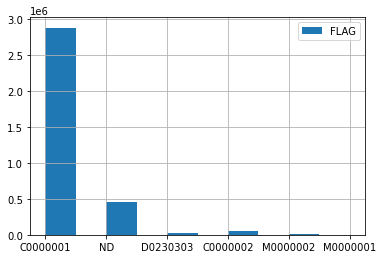

In [125]:
print("\nHISTOGRAMA DE FLAGS")
dsCompleto[dsCompleto['FLAG'].isin(['C0000001','M0000001','ND','D0230303','M0000002','C0000002'])]['FLAG'].hist(legend=True)


HISTOGRAMA DE FLAGS V2


<AxesSubplot:>

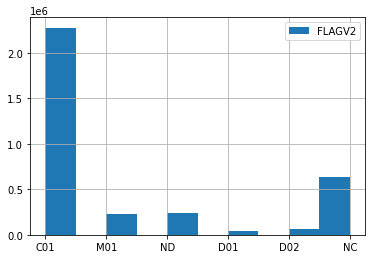

In [220]:
print("\nHISTOGRAMA DE FLAGS V2")
dsCompleto['FLAGV2'].hist(legend=True)


HISTOGRAMA DE PRECIPITACION PARA DATOS CON FLAG M000002
6494


<AxesSubplot:>

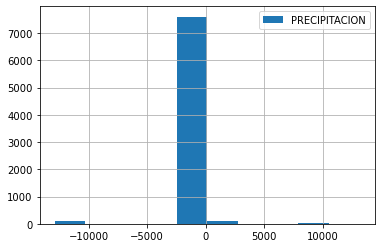

In [126]:
print(f"\nHISTOGRAMA DE PRECIPITACION PARA DATOS CON FLAG M000002")
asd = dsCompleto[dsCompleto['FLAG']=='M0000002']
print(asd[asd['PRECIPITACION']==0]['PRECIPITACION'].count())
asd['PRECIPITACION'].hist(legend=True)


DISTRIBUCION FLAGV2 DE M0000002
TOTAL : 8547


<AxesSubplot:>

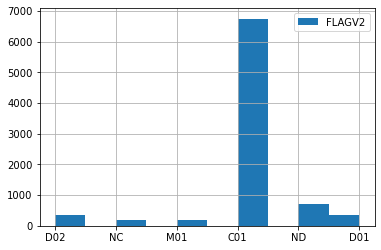

In [18]:
print("\nDISTRIBUCION FLAGV2 DE M0000002")
dfM2_1 = dsCompleto[dsCompleto['FLAG']=='M0000002']
print(f"TOTAL : {len(dfM2_1)}")
dfM2_1['FLAGV2'].hist(legend=True)

TOTAL:    6745
CEROS:    6459
NO CEROS: 286

HISTOGRAMA DE PRECIPITACION PARA DATOS M000002 -> C01 (SIN CEROS)


<AxesSubplot:>

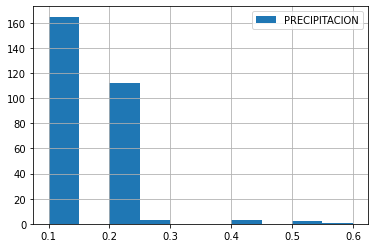

In [217]:

print(f"TOTAL:    {len(dfM2_1[dfM2_1['FLAGV2']=='C01'])}")
print(f"CEROS:    {len(dfM2_1[(dfM2_1['FLAGV2']=='C01') & (dfM2_1['PRECIPITACION']==0)])}")
print(f"NO CEROS: {len(dfM2_1[(dfM2_1['FLAGV2']=='C01') & (dfM2_1['PRECIPITACION']!=0)])}")

print(f'\nHISTOGRAMA DE PRECIPITACION PARA DATOS M000002 -> C01 (SIN CEROS)')
dfM2_1[(dfM2_1['FLAGV2']=='C01') & (dfM2_1['PRECIPITACION']>0)]['PRECIPITACION'].hist(legend=True)

TOTAL:    204
CEROS:    35
NO CEROS: 169

HISTOGRAMA DE PRECIPITACION PARA DATOS M000002 -> NC (SIN CEROS)


<AxesSubplot:>

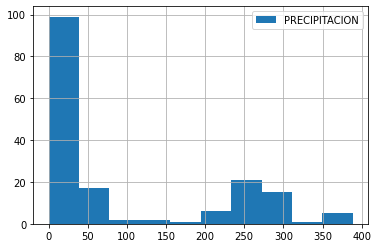

In [221]:
print(f"TOTAL:    {len(dfM2_1[dfM2_1['FLAGV2']=='NC'])}")
print(f"CEROS:    {len(dfM2_1[(dfM2_1['FLAGV2']=='NC') & (dfM2_1['PRECIPITACION']==0)])}")
print(f"NO CEROS: {len(dfM2_1[(dfM2_1['FLAGV2']=='NC') & (dfM2_1['PRECIPITACION']!=0)])}")

print(f'\nHISTOGRAMA DE PRECIPITACION PARA DATOS M000002 -> NC (SIN CEROS)')
dfM2_1[(dfM2_1['FLAGV2']=='NC') & (dfM2_1['PRECIPITACION']>0)]['PRECIPITACION'].hist(legend=True)

TOTAL:    723
CEROS:    0
NO CEROS: 723

HISTOGRAMA DE PRECIPITACION PARA DATOS M000002 -> D01/D02 (SIN CEROS)


<AxesSubplot:>

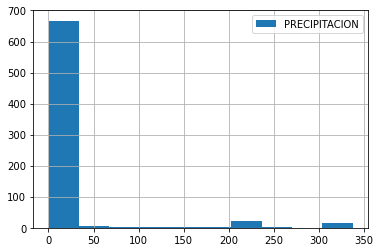

In [222]:
print(f"TOTAL:    {len(dfM2_1[dfM2_1['FLAGV2'].isin(['D01','D02'])])}")
print(f"CEROS:    {len(dfM2_1[(dfM2_1['FLAGV2'].isin(['D01','D02'])) & (dfM2_1['PRECIPITACION']==0)])}")
print(f"NO CEROS: {len(dfM2_1[(dfM2_1['FLAGV2'].isin(['D01','D02'])) & (dfM2_1['PRECIPITACION']!=0)])}")


print(f'\nHISTOGRAMA DE PRECIPITACION PARA DATOS M000002 -> D01/D02 (SIN CEROS)')
dfM2_1[(dfM2_1['FLAGV2'].isin(['D01','D02'])) & (dfM2_1['PRECIPITACION']>0)]['PRECIPITACION'].hist(legend=True)

TOTAL:    173
CEROS:    0
NO CEROS: 173

HISTOGRAMA DE PRECIPITACION PARA DATOS M000002 -> M01 (SIN CEROS)


<AxesSubplot:>

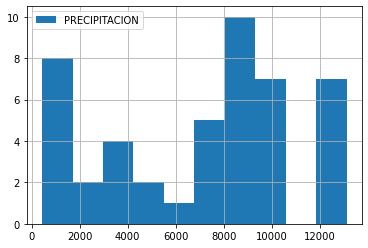

In [223]:
print(f"TOTAL:    {len(dfM2_1[dfM2_1['FLAGV2']=='M01'])}")
print(f"CEROS:    {len(dfM2_1[(dfM2_1['FLAGV2']=='M01') & (dfM2_1['PRECIPITACION']==0)])}")
print(f"NO CEROS: {len(dfM2_1[(dfM2_1['FLAGV2']=='M01') & (dfM2_1['PRECIPITACION']!=0)])}")

print(f'\nHISTOGRAMA DE PRECIPITACION PARA DATOS M000002 -> M01 (SIN CEROS)')
dfM2_1[(dfM2_1['FLAGV2']=='M01') & (dfM2_1['PRECIPITACION']>0)]['PRECIPITACION'].hist(legend=True)

In [ ]:
"""
Comprobamos con imagenes satelitales
"""

In [38]:
#Se obtiene la matriz que representa la imagen satelital con nombre "filename"
def getMatriz(filename, imprimir=0):    
    start_time = time.time()
    try:
        ds = Dataset(filename)
    except:
        print("No se pudo leer el archivo")
        print(filename)
        return np.asarray([-1])
    
    #Obteine los datos de la imagen satelital
    field = ds.variables['CMI'][:].data.astype(np.uint8)
        
    if imprimir:
        print(f"Tiempo en leer imagen satelital: %.5fs" % (time.time() - start_time))
        
    return field

In [85]:
#Devuelve np.Array de las matrices de colores de cada producto en products (C08,C07 o C13)
def leerImagenArea(fecha,path_imagenes, products,times ,imprimir=0): 
    try:   
        year,month,day,hour = fecha.split('-')        
   
    except:
        print("No se pudo leer la fecha")
        print(fecha)
        return [-1]
       
    #Se define el producto 
    mapaArrays = []  
    dimTime = len(times) 
    
    start_time = time.time()
    for j in range(6):
        filename = path_imagenes + 'PNG/' + fecha + '/' + fecha + '_' + str(j) + '.png'
        image = Image.open(filename)          
        mapaArrays.append(np.asarray(image))
    
    #img = [Image.fromarray(img) for img in mapaArrays]
    img = np.stack(mapaArrays, axis=0)
        
    
    
    if imprimir:
        print(f"Tiempo tomado en obtener matrices de un dato para {len(products)} productos: %.2fs" % (time.time() - start_time))
       
    
    return img       

In [89]:
#Para un conjunto de estaciones (dataframe), agrega su posicion XO(longitud), XA(latitud)

#Como input recibe un string que es el directoeio de una imagen satelital (.nc),
#devuelve la matriz que representa esta imagen numpy.array(1200,950)
def getMapFile(imagenFile,mersh=0,imprimir=0):    
    try:
        ds = Dataset(imagenFile)      
    except:
        print("No se pudo leer los archivos de imagen")
        print(imagenFile)
        return -1,-1

    # convierte el formato de la variable de Int16 a Float32 y guarda el resultado
    field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data
    if imprimir:
        dibujar(lons,lats,field,mersh)
        
    return lons, lats , field  

In [200]:
def dibujar(lons,lats,field,estaciones,codigo,mersh=1):    
    if mersh:
        #field=  np.resize(f,(len(lats),len(lons)))
        lons, lats = np.meshgrid(lons, lats)  
    else:
        field = field
    
    x,y = getCoord(estaciones, codigo)
    print(x,y)
    
    # realiza el grafico
    fig = plt.figure('ABI', figsize=(4,4), dpi=150)
    ax = fig.add_axes([0.1,0.1,0.8,0.8], projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.BORDERS)
    img = ax.pcolormesh(lons, lats, field, cmap=plt.cm.Greys, transform=ccrs.PlateCarree())
    plt.plot(x,y, marker='o', color='red',alpha=0.45)  
    plt.colorbar(img)    
      
    #plt.clf()
    plt.show()    
    return 

In [201]:
def getCoord(estaciones, codigo):
    est = pd.read_csv(estaciones)
    X = est[est['CODE']==f'X{codigo}'].iloc[0]    
    return X['LON'], X['LAT']    

In [202]:
def graficarMALOS(df, Festaciones, imagenTest, path_imagenes, products, times):
    for i in df.index: 
        fecha = datetime.datetime.strptime(df['FECHA'][i], '%d/%m/%Y').strftime('%Y-%m-%d') + '-' + df['HORA'][i].split(':')[0]        
        xT = leerImagenArea(fecha,path_imagenes, products,times)
        lons, lats , field  = getMapFile(imagenTest)  
        dibujar(lons,lats,xT[0,:,:,0],Festaciones,df['CODIGO'][i])  
        return xT, lons, lats
        

-73.67925 -2.48757


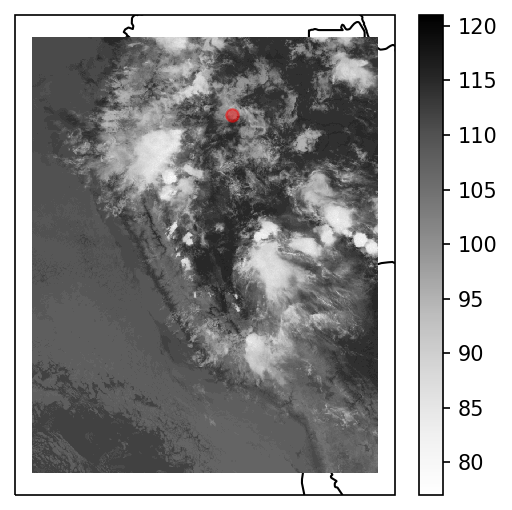

In [203]:
xT, lons, lats = graficarMALOS(d0.head(2), Festaciones, imagenTest, path_imagenes, products, times)

In [199]:
print(lats.max())
print(lats.min())

1.3783783783783794
-20.225225225225227


In [192]:
print(lons.max())
print(lons.min())

-66.45045045045045
-83.54954954954955


In [134]:
d0 = dfM2_1[(dfM2_1['FLAGV2']=='C01') & (dfM2_1['PRECIPITACION']==0)] 
d0 = shuffle(d0)

d1 = dfM2_1[(dfM2_1['FLAGV2']=='C01') & (dfM2_1['PRECIPITACION']!=0)]
d1 = shuffle(d1)